In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
import string
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,concatenate, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
from keras.models import load_model

# Image Feature Extraction

In [6]:
images = 'images/'
img = glob.glob(images+'*.png')

In [7]:
img[:8]

['images\\1.png',
 'images\\10.png',
 'images\\100.png',
 'images\\1000.png',
 'images\\1001.png',
 'images\\1002.png',
 'images\\1003.png',
 'images\\1004.png']

In [8]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [9]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


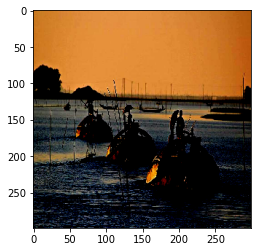

In [7]:
plt.imshow(np.squeeze(preprocess(img[5775])))

In [10]:
model = InceptionV3(weights='imagenet')
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)
print(model_new.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 35, 35, 64)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 35, 35, 64)   192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 35, 35, 96)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 35, 35, 64)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 35, 35, 64)   0           batch_normalization_19[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 17, 17, 192)  576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 17, 17, 192)  576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 17, 17, 192)  576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 17, 17, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 17, 17, 192)  0           batch_normalization_40[0][0]     
__________

batch_normalization_73 (BatchNo (None, 17, 17, 192)  576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 17, 17, 192)  0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 17, 17, 192)  258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 17, 17, 192)  576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 2048)         0           mixed10[0][0]                    
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________
None


In [ ]:
encoding_train = {}
for img in tqdm(img):
    encoding_train[img[len(images):]] = encode(img)

In [ ]:
#with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    #pickle.dump(encoding_train, encoded_pickle) 

In [12]:
cd F:\Image captioning dataset\Bangla lekha captions\All files

F:\Image captioning dataset\Bangla lekha captions\All files


In [13]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [14]:
encoding_train['4.png'].shape

(2048,)

# Description Data Preparating

In [17]:
token = 'Final_1st_annotation_part.txt'

In [18]:
captions = open(token,encoding='utf8').read().strip().split('\n')

In [19]:
len(captions)

9154

In [20]:
captions[:8]

['1.png\tতিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।',
 '2.png\tজলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছে। তাদের পিছনে সবুজ গাছ আছে।',
 '3.png\tঅনেক মেয়ে মানুষ বসে আছে।',
 '4.png\tঅনেক মানুষ একসাথে বসে কাজ করছে।',
 '5.png\tছয় জন মানুষ দাড়িয়ে আছে।',
 '6.png\tএক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে।',
 '7.png\tআবছা অন্ধকারে এক জন মানুষ দাড়িয়ে আছে। পিছনে মানুষ গুলোর চেহারা বোঝা যাচ্ছে না।',
 '8.png\tতিন জন মানুষ আছে। এক জন মাথায় ছাতা ধরে আছে।']

In [21]:
descriptions = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])]
    if row[0] in descriptions:
        continue
    else:
        descriptions[row[0]] = [row[1]]
print('Loaded: %d ' % len(descriptions))

Loaded: 9154 


In [22]:
descriptions

{'1.png': ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।'],
 '2.png': ['জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছে। তাদের পিছনে সবুজ গাছ আছে।'],
 '3.png': ['অনেক মেয়ে মানুষ বসে আছে।'],
 '4.png': ['অনেক মানুষ একসাথে বসে কাজ করছে।'],
 '5.png': ['ছয় জন মানুষ দাড়িয়ে আছে।'],
 '6.png': ['এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে।'],
 '7.png': ['আবছা অন্ধকারে এক জন মানুষ দাড়িয়ে আছে। পিছনে মানুষ গুলোর চেহারা বোঝা যাচ্ছে না।'],
 '8.png': ['তিন জন মানুষ আছে। এক জন মাথায় ছাতা ধরে আছে।'],
 '9.png': ['খালি গায়ে একটি বাচ্চা ছাতার নিচে বসে কাজ করছে। এখানে অনেক ইটের টুকরা আছে। '],
 '10.png': ['একজন মেয়ে  শাড়ি পরে দাড়িয়ে আছে। পেছনে একটি ঘর আছে।'],
 '11.png': ['একটি বাচ্চা মানুষ বসে কাজ করছে। সে একটি গেঞ্জি ও প্যান্ট পরিধান করে আছে।'],
 '12.png': ['নিচে সবুজ মাঠ আছে। উপরে আছে নীল আকাশ ও সাদা মেঘ।'],
 '13.png': ['অল্প আলোতে একজন মানুষ বসে আছে।'],
 '14.png': ['তিনজন ছেলে মানুষ আছে। একজন মানুষ সবজি বিক্রি করছে। একজন মানুষ রাস্তা দিয়ে রিক্সা নিয়ে যাচ্ছে।'],


In [23]:
caps = []
for key, val in descriptions.items():
        caps.append('<start> ' + str(val) + ' <end>')

In [24]:
caps[:8]

["<start> ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।'] <end>",
 "<start> ['জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছে। তাদের পিছনে সবুজ গাছ আছে।'] <end>",
 "<start> ['অনেক মেয়ে মানুষ বসে আছে।'] <end>",
 "<start> ['অনেক মানুষ একসাথে বসে কাজ করছে।'] <end>",
 "<start> ['ছয় জন মানুষ দাড়িয়ে আছে।'] <end>",
 "<start> ['এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে।'] <end>",
 "<start> ['আবছা অন্ধকারে এক জন মানুষ দাড়িয়ে আছে। পিছনে মানুষ গুলোর চেহারা বোঝা যাচ্ছে না।'] <end>",
 "<start> ['তিন জন মানুষ আছে। এক জন মাথায় ছাতা ধরে আছে।'] <end>"]

In [25]:
words = [i.split() for i in caps]

In [26]:
words

[['<start>',
  "['তিন",
  'জন',
  'মেয়ে',
  'মানুষ',
  'আছে।',
  'এক',
  'জন',
  'দাড়িয়ে',
  'আছে',
  'আর',
  'দুই',
  'জন',
  'বসে',
  "আছে।']",
  '<end>'],
 ['<start>',
  "['জলাশয়",
  'এ',
  'একজন',
  'ছেলে',
  'মানুষ',
  'ও',
  'একটি',
  'বাচ্চা',
  'মানুষ',
  'আছে।',
  'তাদের',
  'পিছনে',
  'সবুজ',
  'গাছ',
  "আছে।']",
  '<end>'],
 ['<start>', "['অনেক", 'মেয়ে', 'মানুষ', 'বসে', "আছে।']", '<end>'],
 ['<start>', "['অনেক", 'মানুষ', 'একসাথে', 'বসে', 'কাজ', "করছে।']", '<end>'],
 ['<start>', "['ছয়", 'জন', 'মানুষ', 'দাড়িয়ে', "আছে।']", '<end>'],
 ['<start>',
  "['এক",
  'জন',
  'মেয়ে',
  'মানুষ',
  'মাথায়',
  'ঘোমটা',
  'দিয়ে',
  'কাজ',
  'করছে।',
  'মাটিতে',
  'বিভিন্ন',
  'রঙের',
  'মসলা',
  "আছে।']",
  '<end>'],
 ['<start>',
  "['আবছা",
  'অন্ধকারে',
  'এক',
  'জন',
  'মানুষ',
  'দাড়িয়ে',
  'আছে।',
  'পিছনে',
  'মানুষ',
  'গুলোর',
  'চেহারা',
  'বোঝা',
  'যাচ্ছে',
  "না।']",
  '<end>'],
 ['<start>',
  "['তিন",
  'জন',
  'মানুষ',
  'আছে।',
  'এক',
  'জন',
  'মাথায়',
  'ছাতা',
  'ধরে',
  "

In [27]:
unique = []
for i in words:
    unique.extend(i)

In [28]:
unique = list(set(unique))
len(unique)

3151

In [29]:
word2idx = {val:index for index, val in enumerate(unique)}
idx2word = {index:val for index, val in enumerate(unique)}

In [30]:
word2idx["<start>"]

2330

In [31]:
idx2word[643]

'উকি'

In [32]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

31

In [33]:
c

['<start>',
 "['একটা",
 'ছেলে',
 'লাফ',
 'দিচ্ছে',
 'আর',
 'আকাশে',
 'এক',
 'ঝাঁক',
 'পাখি',
 "উড়ছে।']",
 '<end>']

In [34]:
#f = open('Final_1st_annotation_part_training_dataset.txt', 'w' ,encoding='utf8')
#f.write("image_id\tcaptions\n")

In [85]:
#for key, val in descriptions.items():
#        f.write(key[:] + "\t" + "<start> " + str(val) +" <end>" + "\n")
#f.close()

In [35]:
df = pd.read_csv('Final_1st_annotation_part_training_dataset.txt', delimiter='\t')

In [36]:
df

,image_id,captions
0,1.png,<start> ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে ...
1,2.png,<start> ['জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চ...
2,3.png,<start> ['অনেক মেয়ে মানুষ বসে আছে।'] <end>
3,4.png,<start> ['অনেক মানুষ একসাথে বসে কাজ করছে।'] <end>
4,5.png,<start> ['ছয় জন মানুষ দাড়িয়ে আছে।'] <end>
...,...,...
9149,9150.png,<start> ['একজন বৃদ্ধ লোক মাথায় হাত দিয়ে দাঁড়িয়...
9150,9151.png,<start> ['কয়েকজন ছেলে মেয়ে একসাথে নৌকায় বসে নৌ...
9151,9152.png,<start> ['সবুজ ধান ক্ষেতের মধ্যে দিয়ে কয়েকজন ছ...
9152,9153.png,<start> ['সমুদ্রের মধ্যে একজন লোক জাল ফেলে মাছ...


In [37]:
c = [i for i in df['captions']]
len(c)

9154

In [38]:
imgs = [i for i in df['image_id']]
len(imgs)

9154

In [39]:
a = c[-1]
a, imgs[-1]

("<start> ['একটা ছেলে লাফ দিচ্ছে আর আকাশে এক ঝাঁক পাখি উড়ছে।'] <end>",
 '9154.png')

In [40]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 2330
['একটা => 2525
ছেলে => 653
লাফ => 1505
দিচ্ছে => 348
আর => 2303
আকাশে => 309
এক => 2794
ঝাঁক => 2167
পাখি => 1830
উড়ছে।'] => 492
<end> => 2647


In [41]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [42]:
samples_per_epoch

71670

In [43]:
def data_generator(batch_size = 32):
    
        partial_caps = []
        next_words = []
        images = []
        df = pd.read_csv('Final_1st_annotation_part_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])
        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [np.array(images),np.array(partial_caps)], np.array(next_words)
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [44]:
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="modellogs/{}".format(time()))

In [45]:
import tensorflow as tf
checkpoint_filepath = '/checkpointsforfinalmodel/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)

In [46]:
embedding_size = 300
vocab_size=len(unique)

In [47]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [48]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [49]:
concat_layers = concatenate([image_model.output, caption_model.output])
layer = Bidirectional(LSTM(256, return_sequences=False))(concat_layers)
layer = Dense(vocab_size)(layer)
outlayer = Activation('softmax')(layer)
final_model = Model([image_model.input, caption_model.input], [outlayer])

In [43]:
print(final_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 31)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 31, 300)      945300      embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      dense_1_input[0][0]              
____________________________________________________________________________________________

In [50]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [53]:
history= final_model.fit(data_generator(128), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=2,callbacks=[tensorboard])

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
71670/71670 - 108889s - loss: 0.7577 - accuracy: 0.8176


In [54]:
final_model.fit(data_generator(128), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=2,callbacks=[tensorboard])

71670/71670 - 112296s - loss: 0.2411 - accuracy: 0.9259


In [56]:
final_model.fit(data_generator(128), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=2,callbacks=[tensorboard])

71670/71670 - 112743s - loss: 0.2173 - accuracy: 0.9370


In [58]:
final_model.fit(data_generator(128), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=2,callbacks=[tensorboard])

71670/71670 - 118932s - loss: 0.2260 - accuracy: 0.9378


In [ ]:
#final_model.fit(data_generator(128), steps_per_epoch=samples_per_epoch, epochs=1, verbose=2,callbacks=[tensorboard,model_checkpoint_callback])

In [ ]:
#final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
#                          verbose=2, callbacks=[tensorboard])

In [59]:
#final_model.save_weights('FinalModel_0.2260_loss_acc_0.9378.h5')

In [ ]:
#final_model.load_weights("")

In [60]:
%load_ext tensorboard

In [64]:
%tensorboard --logdir modellogs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 26280.

In [ ]:
#final_model.save_weights('FinalModel_0.2260_loss_acc_0.9378.h5')

# Evolution

In [65]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_train[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [66]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_train[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

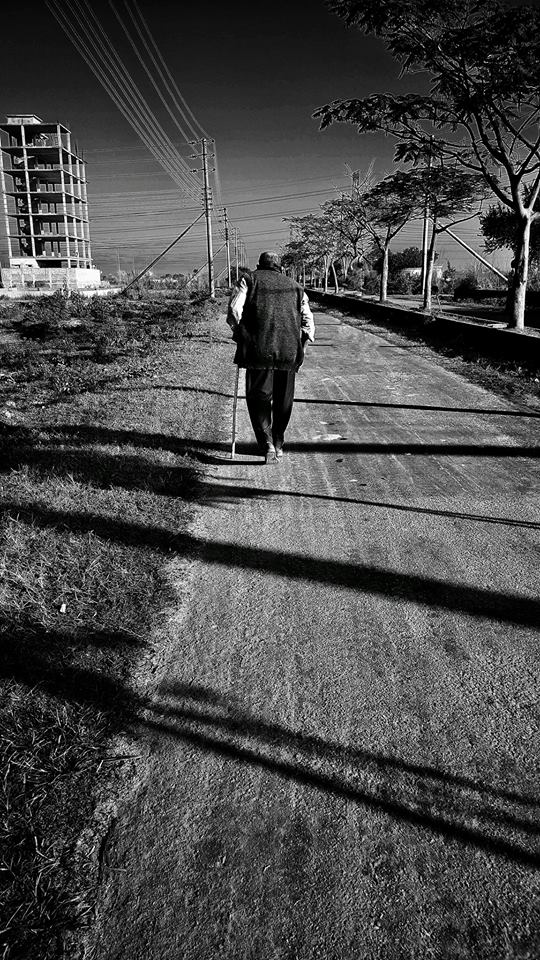

In [74]:
try_image = img[5787]
Image.open(try_image)

In [ ]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: ['একজন মানুষ হেঁটে যাচ্ছে।']
Beam Search, k=3: ['একজন মানুষ হেঁটে যাচ্ছে।']
